# 10. PyTorch 2.0

* Reference coursebook: https://www.learnpytorch.io/pytorch_2_intro/
* Release notes: https://pytorch.org/blog/pytorch-2.0-release/

In [1]:
import torch
import torchvision

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.7.1+cu126
0.22.1+cu126


## Quick code examples

### Before PyTorch 2.0

In [3]:
model = torchvision.models.resnet50()

### After PyTorch 2.0

In [4]:
model = torchvision.models.resnet50() # note: this could be any model
compiled_model = torch.compile(model)

# Training code here

# Testing code here

## 0. Getting setup

In [5]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.7.1+cu126
0.22.1+cu126


## 1. Get GPU info

Why get GPU info?

Because PyTorch 2.0 features (`torch.complie()`) work best on newer Nvidia GPUs

Well, what's newer Nvidia GPU

To find our if your GPU is compability scores

If your GPU has a score of 8.0+, it can leverage *most* if not *all* of new PyTorch 2.0 features

GPUs under 8.0 can still leverage PyTorch 2.0, however the improvements may not be as noticable as those with 8.0+

In [6]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find("failed") >= 0:
        print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

    # Get GPU name
    gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_name[1]
    GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
    print(f'GPU name: {GPU_NAME}')

    # Get GPU capability score
    GPU_SCORE = torch.cuda.get_device_capability()
    print(f"GPU capability score: {GPU_SCORE}")
    if GPU_SCORE >= (8, 0):
        print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
    else:
        print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")
    
    # Print GPU info
    print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: NVIDIA_GeForce_RTX_3060_Laptop_GPU
GPU capability score: (8, 6)
GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.
GPU information:
Sat Aug 30 18:34:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.181                Driver Version: 570.181        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              8W /  115W |    1014MiB /   

### 1.1 Globally set devices

Previously, we've set the device of our tensors/models using `.to(device)`.

* `tensor.to(device)`
* `model.to(device)`

But in PyTorch 2.0, it's possible to set the device with a context manager as well as a global device - https://pytorch.org/blog/pytorch-2.0-release/#beta-torchset_default_device-and-torchdevice-as-context-manager 

See the docs - https://pytorch.org/tutorials/recipes/recipes/changing_default_device.html 

In [7]:
import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu" 

# Set the device with context manager (requires PyTorch 2.x+)
with torch.device(device):
    # All tensors or PyTorch objects created in the context manager will be on the target device without using .to()
    layer = torch.nn.Linear(20, 30)
    print(f"Layer weights are on device: {layer.weight.device}")
    print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


In [8]:
import torch

# Set the device globally (requires pytorch 2.x+)
torch.set_default_device("cpu") 

# All tensors or PyTorch objects created from here on out will be on the target device without using .to()
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cpu
Layer creating data on device: cpu


## 2. Setting up the experiments 

Time to test speed!

To keep things simple, we'll run 4 experiments:

* Model: ResNet50 from torchvision
* Data: CIFAR10 from torchvision
* Epochs: 5 (single run) and 3x5 (multi run)
* Batch size: 128 (note: you may want to change this depending on the amount of memory your GPU has, this tutorial focuses on an A100) 
* Image size: 224 (note: you may want to adjust this given the amount of GPU memory you have)

In [9]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

PyTorch version: 2.7.1+cu126
TorchVision version: 0.22.1+cu126
Using device: cuda


### 2.1 Create model and transforms

* ResNet50 from PyTorch - https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights

In [10]:
# Create model weights and transforms
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2 # .DEFAULT also works here
transforms = model_weights.transforms()

transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [11]:
# Create model
model = torchvision.models.resnet50(weights=model_weights)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/michal-chojna/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:09<00:00, 10.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# Count the number of parameters in the model
total_params = sum(
    param.numel() for param in model.parameters() # count all parameters
    # param.numel() for param in model.parameters() if param.requires_grad = True # only count parameters that are trainable
)
total_params

25557032

**Note:** PyTorch 2.0 *relative* speedups will be most noticeable when as much of the GPU as possible is being used. This means a larger model (more trainable parameters) may take longer to train on the whole but will relatively faster. E.g. a model with 1M parameters may take ~10 minutes to train but a model with 25M parameters may take ~20 minutes to train. 

In [13]:
def create_model(num_classes=10):
    """
    Creates a resnet50 model with transforms and returns them both.
    """ 
    model_weights = torchvision.models.ResNet50_Weights.DEFAULT
    transforms = model_weights.transforms()
    model = torchvision.models.resnet50(weights=model_weights)

    # Adjust the head layer to suit our number of classes
    model.fc = torch.nn.Linear(in_features=2048,
                               out_features=num_classes)

    return model, transforms

model, transforms = create_model()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 2.2 Speedups are most noticeable when a large portion of the GPU(s) is being used

Since modern GPUs are so *fast* at performing operations, you will often notice the majority of *relative* speedups when as much data as possible is on the GPU.

In practice, you generally want to use as much of your GPU memory as possible.

* Increasing the batch size - we've been using batch size 32 but for GPUs with a larger memory capacity you'll generally want to use as large as possible, e.g. 128, 256, 512, etc
* Increasing data size - for example instead of using images that are 32x32, use 224x224 or 336x336, also you could use an increased embedding size for your data 
* Increase the model size - for example instead of using a model with 1M parameters, use a model with 10M parameters
* Decreasing data transfer - since bandwidth costs (transferring data) will slow down a GPU (because it wants to compute on data) 

As a result of doing the above, your relative speedups should be better.

E.g. overall training time may take longer but not linearly. 

Resource for learning how to improve PyTorch model speed - https://sebastianraschka.com/blog/2023/pytorch-faster.html 

**Note:** This concept of using as much data on the GPU as possible isn't restricted specificially to PyTorch 2.0, it applies to all versions on PyTorch and basically all models that train on GPUs.

### 2.3 Checking the memory limits of our GPU

Can do so using `torch.cuda` - https://pytorch.org/docs/stable/generated/torch.cuda.mem_get_info.html#torch.cuda.mem_get_info 

In [14]:
# Check available GPU memory and total GPU memory
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info() 
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB") 
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB") 

Total free GPU memory: 4.88 GB
Total GPU memory: 6.098 GB


* If the GPU has 16GB+ of free memory, set batch size to 128
* If the GPU has less than 16GB of free, set batch size to 32

In [15]:
# Set batch size depending on amount of GPU memory
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
    BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
    IMAGE_SIZE = 224
    print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
else:
    BATCH_SIZE = 32
    IMAGE_SIZE = 128
    print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")

GPU memory available is 4.88 GB, using batch size of 32 and image size 128


In [16]:
transforms.crop_size = 224
transforms.resize_size = 224 
print(f"Updated data transforms:\n{transforms}")

Updated data transforms:
ImageClassification(
    crop_size=224
    resize_size=224
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 2.4 More potential speedups with TF32

TF32 = TensorFloat32

TesnorFloat32 = a datatype that bridges Float32 and Float16

Float32 = a number is represented by 32 bytes (e.g. 010101010110011 = 7)

Float16 = a number is represented by 16 bytes (e.g. 01010101 = 4)

See more on precision in computing: https://en.wikipedia.org/wiki/Precision_(computer_science) 

What we want is:
1. Fast model training 
2. Accurate model training

TensorFloat32 = a datatype from NVIDIA which combines float32 and float16

TF32 is available on Ampere GPUs+ 

In [17]:
GPU_SCORE

(8, 6)

In [18]:
if GPU_SCORE >= (8, 0): # check if GPU is compatiable with TF32
    print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32")
    torch.backends.cuda.matmul.allow_tf32 = True
else:
    print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 not available") 
    torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (8, 6), enabling TensorFloat32


### 2.5 Preparing datasets

As before, we discussed we're going to use CIFAR10.

Homepage - https://www.cs.toronto.edu/~kriz/cifar.html 

We can download the dataset from torchvision - https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html 

In [19]:
transforms

ImageClassification(
    crop_size=224
    resize_size=224
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [20]:
# Create train and test datasets
import torchvision
train_dataset = torchvision.datasets.CIFAR10(root=".", # where to store data
                                             train=True, # do we want training dataset?
                                             download=True,
                                             transform=transforms
                                             )

test_dataset = torchvision.datasets.CIFAR10(root=".",
                                            train=False,
                                            download=True,
                                            transform=transforms)

# Get the length of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

100%|██████████| 170M/170M [01:39<00:00, 1.71MB/s] 


[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


In [21]:
train_dataset[0][1]

6

### 2.6 Create DataLoaders

Next:
* Turn datasets into DataLoaders

In [22]:
BATCH_SIZE * 2

64

In [23]:
from torch.utils.data import DataLoader

import os
NUM_WORKERS = os.cpu_count() # we want highest number of CPU cores to load data to GPU 

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

# Print details:
print(f"Train dataloader num batches: {len(train_dataloader)} of batch size: {BATCH_SIZE}")
print(f"Test dataloader num batches: {len(test_dataloader)} of batch size: {BATCH_SIZE}")
print(f"Using num workers to load data (more is generally better): {NUM_WORKERS}")

Train dataloader num batches: 1563 of batch size: 32
Test dataloader num batches: 313 of batch size: 32
Using num workers to load data (more is generally better): 20


### 2.7 Creating training and test loops 

Want to create: 
* Training and test loops + a timing step for each, so we know how long our models take to train/test

We covered this functionality in previous sections, one is here: https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them

In [24]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader), 
        desc=f"Training Epoch {epoch}", 
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader), 
      desc=f"Testing Epoch {epoch}", 
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch, 
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time
      
      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

## 3. Time models across a single run

Experiment 1: single run without `torch.compile()` for 5 epochs

### 3.1 Experiment 1 - Single run, no compile

In [25]:
# Set the number of epochs
NUM_EPOCHS = 5

# Set the learning rate as a constant
LEARNING_RATE = 0.003

**Note:** Depending on your GPU/machine, the following code may take a while to run. E.g. in my experience on an A100, it takes about ~7 minutes.

In [26]:
# Create model
model, _ = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Train model and track the results
single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2239 | train_acc: 0.5580 | test_loss: 0.9307 | test_acc: 0.6638 | train_epoch_time: 297.8110 | test_epoch_time: 21.9382


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7774 | train_acc: 0.7281 | test_loss: 0.7316 | test_acc: 0.7457 | train_epoch_time: 298.3627 | test_epoch_time: 22.0264


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5715 | train_acc: 0.8023 | test_loss: 0.5548 | test_acc: 0.8112 | train_epoch_time: 298.4542 | test_epoch_time: 22.1024


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4396 | train_acc: 0.8482 | test_loss: 0.5240 | test_acc: 0.8189 | train_epoch_time: 298.3814 | test_epoch_time: 22.0364


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3368 | train_acc: 0.8840 | test_loss: 0.4792 | test_acc: 0.8363 | train_epoch_time: 298.3772 | test_epoch_time: 22.1431


### 3.2 Experiment 2, single, using `torch.compile()`

Same setup as experiment 1 except with the new line `torch.compile()`.

In [27]:
# Create model and transforms
model, _ = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Compile the model (requires PyTorch 2.0+)
import time
compile_start_time = time.time()

### New in PyTorch 2.x ###
compile_model = torch.compile(model) # NOTE: this should ideally be "compiled_model" not "compile_model"
compile_model.to(device) # make sure compiled on device

compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time

print(f"Time to compile: {compile_time} |\nNote: the first time you compile a model/train a compiled model, the first epoch may take longer due to optimizations happening behind the scenes")

# Train the compiled model
single_run_compile_results = train(model=compile_model, # NOTE: this is an error! (leaving it in for future reference)
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Time to compile: 0.003520488739013672 |
Note: the first time you compile a model/train a compiled model, the first epoch may take longer due to optimizations happening behind the scenes


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

W0830 19:03:06.170000 23116 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2075 | train_acc: 0.5636 | test_loss: 1.0842 | test_acc: 0.6218 | train_epoch_time: 584.5481 | test_epoch_time: 48.9579


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7595 | train_acc: 0.7338 | test_loss: 0.7960 | test_acc: 0.7327 | train_epoch_time: 546.0587 | test_epoch_time: 34.9281


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5601 | train_acc: 0.8071 | test_loss: 0.5705 | test_acc: 0.8088 | train_epoch_time: 537.1122 | test_epoch_time: 30.7670


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4364 | train_acc: 0.8509 | test_loss: 0.5144 | test_acc: 0.8231 | train_epoch_time: 492.2504 | test_epoch_time: 20.3095


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3380 | train_acc: 0.8844 | test_loss: 0.5096 | test_acc: 0.8316 | train_epoch_time: 268.7712 | test_epoch_time: 17.8768


In [28]:
# Create model and transforms
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Compile the model and time how long it takes
compile_start_time = time.time()

### New in PyTorch 2.x ###
compiled_model = torch.compile(model)
##########################

compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time
print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")

# Train the compiled model
single_run_compile_results = train(model=compiled_model,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Time to compile: 0.004044771194458008 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1844 | train_acc: 0.5731 | test_loss: 0.9017 | test_acc: 0.6765 | train_epoch_time: 268.6990 | test_epoch_time: 17.9147


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7238 | train_acc: 0.7453 | test_loss: 0.6174 | test_acc: 0.7840 | train_epoch_time: 268.8625 | test_epoch_time: 17.8575


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5413 | train_acc: 0.8136 | test_loss: 0.5665 | test_acc: 0.8040 | train_epoch_time: 268.8870 | test_epoch_time: 17.8920


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4234 | train_acc: 0.8531 | test_loss: 0.5427 | test_acc: 0.8189 | train_epoch_time: 269.0441 | test_epoch_time: 17.8529


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3285 | train_acc: 0.8878 | test_loss: 0.4883 | test_acc: 0.8387 | train_epoch_time: 268.8658 | test_epoch_time: 17.9185


### 3.3 Compare the results of experiment 1 and 2

In [29]:
# Turn experiment results into dataframes
import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results) 

In [30]:
single_run_no_compile_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.223880,0.557981,0.930702,0.663838,297.810954,21.938202
1,0.777379,0.728067,0.731552,0.745707,298.362742,22.026431
2,0.571544,0.802263,0.554796,0.811202,298.454247,22.102367
3,0.439618,0.848229,0.524038,0.818890,298.381409,22.036403
4,0.336767,0.883957,0.479247,0.836262,298.377157,22.143120


In [31]:
single_run_compile_results_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.184381,0.573137,0.901653,0.676518,268.699014,17.914651
1,0.723759,0.745341,0.617378,0.784046,268.862472,17.857452
2,0.541280,0.813600,0.566505,0.804014,268.887048,17.892024
3,0.423362,0.853087,0.542689,0.818890,269.044118,17.852882
4,0.328469,0.887756,0.488302,0.838658,268.865781,17.918504


In [32]:
# Create filename to save the results
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame, 
                          compiled_results: pd.DataFrame, 
                          multi_runs: bool=False, 
                          num_runs: int=0, 
                          save: bool=False, 
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:
    
    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

[INFO] Save path for single run results: pytorch_2_results/figures/single_run_NVIDIA_GeForce_RTX_3060_Laptop_GPU_ResNet50_CIFAR10_128_train_epoch_time.png
Mean train epoch time difference: -9.858% (negative means faster)
Mean test epoch time difference: -18.877% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/single_run_NVIDIA_GeForce_RTX_3060_Laptop_GPU_ResNet50_CIFAR10_128_train_epoch_time.png


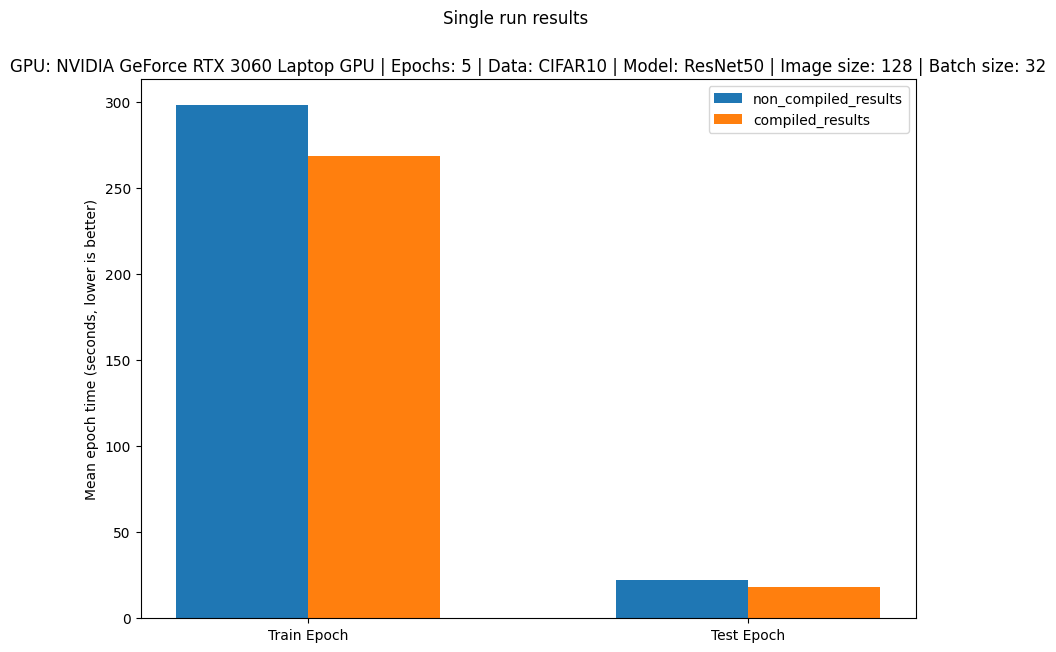

In [34]:
# Create directory for saving figures
import os
dir_to_save_figures_in = "pytorch_2_results/figures/"
os.makedirs(dir_to_save_figures_in, exist_ok=True)

# Create a save path for the single run results
save_path_single_run = f"{dir_to_save_figures_in}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Save path for single run results: {save_path_single_run}")

# Plot the results and save the figure(s)
plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df,
                      compiled_results=single_run_compile_results_df,
                      multi_runs=False,
                      save_path=save_path_single_run,
                      save=True)

### 3.4 Save single run results to file with GPU details

In [35]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

# Save the results
single_run_no_compile_results_df.to_csv(single_run_no_compile_save_path)
single_run_compile_results_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3060_Laptop_GPU.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3060_Laptop_GPU.csv


## 4. Time models across multiple runs

Time for multi-run experiments!

* Experiment 3 - 3x5 epochs without `torch.compile()`
* Experiment 4 - 3x5 epochs with `torch.compile()`

Before running experiment 3 and 4, let's create 3 functions:

1. **Experiment 3:** `create_and_train_non_compiled_model()` - creates and trains a model for a single run (can put this function in a loop for mulitple runs).
2. **Experiment 4:** `create_compiled_model()` - creates and compiles a model, returns the compiled model.
3. **Experiment 4:** `train_compiled_model()` - trains a compiled model for a single run (can put this in a loop to train for multiple runs).

In [36]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        disable_progress_bar=False): 

    """
    Create and train a non-compiled PyTorch model.
    """
    model, _ = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)
    
    results = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device,
                    disable_progress_bar=disable_progress_bar)
    
    return results

def create_compiled_model():
  """
  Create a compiled PyTorch model and return it.
  """ 
  model, _ = create_model()
  model.to(device)

  compile_start_time = time.time()

  ### New in PyTorch 2.0!!! ###
  compiled_model = torch.compile(model)

  compile_end_time = time.time()

  compile_time = compile_end_time - compile_start_time

  print(f"[INFO] Model compile time: {compile_time}")

  return compiled_model

def train_compiled_model(model=compiled_model,
                         epochs=NUM_EPOCHS,
                         learning_rate=LEARNING_RATE,
                         disable_progress_bar=False):
  """
  Train a compiled model and return the results.
  """ 
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(compiled_model.parameters(),
                               lr=learning_rate)
  
  compile_results = train(model=model,
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          epochs=epochs,
                          device=device,
                          disable_progress_bar=disable_progress_bar)

  return compile_results


### 4.1 Experiment 3 - Multiple runs, no compile

**Note:** Because we are running multiple runs, the code below may take a while to run. If one single run take ~7 minutes on an A100, the following code could take 20 minutes on an A100. 

> One of the most painful things of machine learning is that models take a while to train and one of the most beautiful things of machine learning is that models take a while to train. So plenty of time to go for a walk.

In [37]:
# Run non-compiled model for multiple runs
NUM_RUNS = 3
NUM_EPOCHS = 5

# Create an empty list to store multiple run results
non_compile_results_multiple_runs = []

# Run non-compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
  print(f"[INFO] Run {i+1} of {NUM_RUNS} for non-compiled model")
  results = create_and_train_non_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=True)
  non_compile_results_multiple_runs.append(results)

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.2420 | train_acc: 0.5553 | test_loss: 1.0177 | test_acc: 0.6420 | train_epoch_time: 296.9146 | test_epoch_time: 22.0148
Epoch: 2 | train_loss: 0.7971 | train_acc: 0.7194 | test_loss: 0.6987 | test_acc: 0.7575 | train_epoch_time: 296.8905 | test_epoch_time: 22.0864
Epoch: 3 | train_loss: 0.5862 | train_acc: 0.7971 | test_loss: 0.5789 | test_acc: 0.8006 | train_epoch_time: 296.9939 | test_epoch_time: 22.0757
Epoch: 4 | train_loss: 0.4527 | train_acc: 0.8452 | test_loss: 0.5117 | test_acc: 0.8234 | train_epoch_time: 296.8059 | test_epoch_time: 22.0253
Epoch: 5 | train_loss: 0.3554 | train_acc: 0.8770 | test_loss: 0.4843 | test_acc: 0.8389 | train_epoch_time: 296.8610 | test_epoch_time: 22.0681
[INFO] Run 2 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.2217 | train_acc: 0.5600 | test_loss: 0.9410 | test_acc: 0.6619 | train_epoch_time: 296.8559 | test_epoch_time: 22.1030
Epoch: 2 | train_loss: 0.7703 | train_acc: 0.729

In [38]:
# Go through the non_compile_results_multiple_runs and create a dataframe for each and then combine each dataframe
non_compile_results_dfs = []
for result in non_compile_results_multiple_runs:
  result_df = pd.DataFrame(result)
  non_compile_results_dfs.append(result_df)
non_compile_results_multiple_runs_df = pd.concat(non_compile_results_dfs)

# Get the average results across the board
non_compile_results_multiple_runs_df = non_compile_results_multiple_runs_df.groupby(non_compile_results_multiple_runs_df.index).mean()
non_compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.242627,0.553136,0.975373,0.654619,296.843595,22.038088
1,0.781211,0.725608,0.757552,0.737786,296.832249,22.070215
2,0.572923,0.801384,0.600505,0.793397,296.789567,22.079897
3,0.445362,0.846856,0.501226,0.828641,296.800212,22.050019
4,0.346018,0.880212,0.501990,0.831802,296.894044,22.044191


### 4.2 Experiment 4, multiple runs, with compile

In [39]:
# Create compiled model
compiled_model = create_compiled_model()

# Create an empty list to store compiled model result runs
compiled_results_multiple_runs = []

# Run compiled model for multiple training runs
for i in tqdm(range(NUM_RUNS)):
  print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
  # Train compiled model and append results (note: model will only be compiled once at the start of the first epoch of the first run)
  results = train_compiled_model(model=compiled_model, 
                                 epochs=NUM_EPOCHS,
                                 disable_progress_bar=False)
  compiled_results_multiple_runs.append(results)

[INFO] Model compile time: 0.0011858940124511719


  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for compiled model


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2404 | train_acc: 0.5493 | test_loss: 0.9762 | test_acc: 0.6571 | train_epoch_time: 268.7885 | test_epoch_time: 17.9003


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7978 | train_acc: 0.7167 | test_loss: 0.7354 | test_acc: 0.7433 | train_epoch_time: 268.9682 | test_epoch_time: 17.9496


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5835 | train_acc: 0.7964 | test_loss: 0.5769 | test_acc: 0.8023 | train_epoch_time: 267.7051 | test_epoch_time: 17.9695


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4505 | train_acc: 0.8451 | test_loss: 0.4867 | test_acc: 0.8319 | train_epoch_time: 267.8925 | test_epoch_time: 17.9224


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3442 | train_acc: 0.8792 | test_loss: 0.4710 | test_acc: 0.8403 | train_epoch_time: 268.4599 | test_epoch_time: 17.8969
[INFO] Run 2 of 3 for compiled model


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2637 | train_acc: 0.9074 | test_loss: 0.4778 | test_acc: 0.8449 | train_epoch_time: 268.4165 | test_epoch_time: 17.8995


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.1832 | train_acc: 0.9351 | test_loss: 0.4843 | test_acc: 0.8519 | train_epoch_time: 268.1393 | test_epoch_time: 17.9156


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.1295 | train_acc: 0.9539 | test_loss: 0.5228 | test_acc: 0.8498 | train_epoch_time: 267.8671 | test_epoch_time: 17.8841


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.0960 | train_acc: 0.9663 | test_loss: 0.5020 | test_acc: 0.8616 | train_epoch_time: 267.5532 | test_epoch_time: 17.9116


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.0790 | train_acc: 0.9725 | test_loss: 0.5234 | test_acc: 0.8610 | train_epoch_time: 267.9244 | test_epoch_time: 17.9493
[INFO] Run 3 of 3 for compiled model


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0787 | train_acc: 0.9731 | test_loss: 0.5000 | test_acc: 0.8678 | train_epoch_time: 267.7492 | test_epoch_time: 17.8954


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.0568 | train_acc: 0.9809 | test_loss: 0.5697 | test_acc: 0.8568 | train_epoch_time: 268.0699 | test_epoch_time: 17.9330


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.0573 | train_acc: 0.9801 | test_loss: 0.5663 | test_acc: 0.8613 | train_epoch_time: 268.0527 | test_epoch_time: 17.9215


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.0486 | train_acc: 0.9829 | test_loss: 0.5772 | test_acc: 0.8617 | train_epoch_time: 268.1291 | test_epoch_time: 17.8706


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.0480 | train_acc: 0.9836 | test_loss: 0.5428 | test_acc: 0.8743 | train_epoch_time: 267.8216 | test_epoch_time: 17.9299


In [40]:
# Want to combine all the results into a single average dataframe
compile_results_df = []
for result in compiled_results_multiple_runs:
  results_df = pd.DataFrame(result)
  compile_results_df.append(results_df)
compile_results_multiple_runs_df = pd.concat(compile_results_df)

# Get the average across all the runs for the compiled model
compile_results_multiple_runs_df = compile_results_multiple_runs_df.groupby(compile_results_multiple_runs_df.index).mean()
compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.527613,0.809934,0.651339,0.789969,268.318054,17.898414
1,0.345949,0.877579,0.596443,0.817359,268.392477,17.932709
2,0.256753,0.910135,0.555357,0.837826,267.874985,17.925050
3,0.198365,0.931435,0.521958,0.851737,267.858261,17.901544
4,0.157072,0.945118,0.512403,0.858526,268.068632,17.925382


### 4.3 Compare results of experiment 3 and 4

Mean train epoch time difference: -9.679% (negative means faster)
Mean test epoch time difference: -18.769% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/multi_run_NVIDIA_GeForce_RTX_3060_Laptop_GPU_ResNet50_CIFAR10_128_train_epoch_time.png


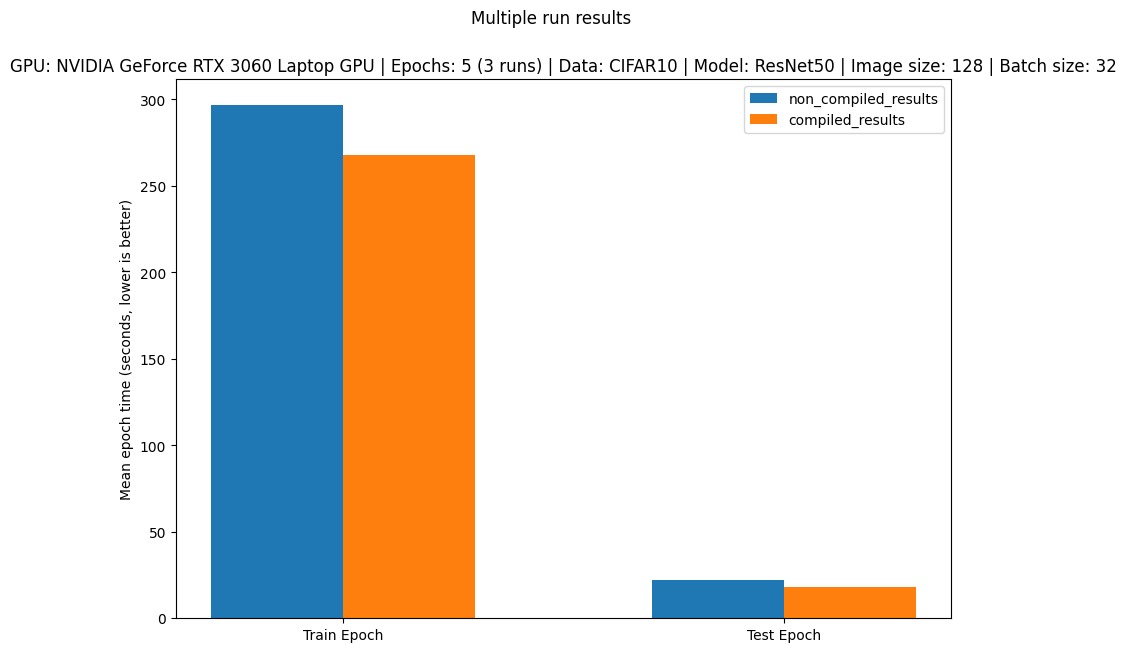

In [41]:
# Create a directory to save the multi-run figure to 
os.makedirs("pytorch_2_results/figures", exist_ok=True)

# Create a path to save the figure for multiple runs
save_path_multi_run = f"pytorch_2_results/figures/multi_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"

# Plot the mean epoch times for experiment 3 and 4
plot_mean_epoch_times(non_compiled_results=non_compile_results_multiple_runs_df, 
                      compiled_results=compile_results_multiple_runs_df, 
                      multi_runs=True, 
                      num_runs=NUM_RUNS, 
                      save_path=save_path_multi_run, 
                      save=True)

### 4.4 Save multi runs results to file with GPU details 

In [42]:
# Make a directory for multi_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
multi_run_no_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_non_compiled_results}"
multi_run_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving experiment 3 non-compiled results to: {multi_run_no_compile_save_path}")
print(f"[INFO] Saving experiment 4 compiled results to: {multi_run_compile_save_path}")

# Save the results
non_compile_results_multiple_runs_df.to_csv(multi_run_no_compile_save_path)
compile_results_multiple_runs_df.to_csv(multi_run_compile_save_path)

[INFO] Saving experiment 3 non-compiled results to: pytorch_2_results/multi_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3060_Laptop_GPU.csv
[INFO] Saving experiment 4 compiled results to: pytorch_2_results/multi_run_results/single_run_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3060_Laptop_GPU.csv


## 5. Possible improvements and extensions 

1. More powerful CPUs - to load data to the GPU as quickly as possible, relative speedups come from using as much of the GPU as possible. 
2. Use mixed precision training - uses a combination of float32 and float16 to train a model (generally improves model training time).
3. Transformer based models may see more *relative* speedups than convolutional - 
4. Train for longer - the longer we train, the more we can benefit from the optimization steps that `torch.compile()` does up front. 

See more here: https://www.learnpytorch.io/pytorch_2_intro/#5-possible-improvements-and-extensions

## 6. Resources to learn more

See here: https://www.learnpytorch.io/pytorch_2_intro/#6-resources-to-learn-more